# Bank Churn Data Cleaning and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DateLocator
from datetime import datetime, date
from dateutil.relativedelta import relativedelta


In [2]:
# Load data
customers_fp = r"C:\Users\GriffenRoweGaddis\OneDrive - Kubrick Group\Desktop\Training\Projects\Bank Churn\data\customers_tm1_e.csv"
tran_fp = r"C:\Users\GriffenRoweGaddis\OneDrive - Kubrick Group\Desktop\Training\Projects\Bank Churn\data\transactions_tm1_e.csv"

cust_df = pd.read_csv(customers_fp)
trans_df = pd.read_csv(tran_fp)

In [4]:
print(cust_df.columns.values)
print(trans_df.columns.values)

['customer_id' 'dob' 'state' 'start_balance' 'creation_date']
['date' 'account_id' 'customer_id' 'amount' 'transaction_date' 'deposit'
 'withdrawal']


In [57]:
cust_df.head()

,customer_id,dob,state,start_balance,creation_date
0,91,1993-07-01,California,10180.56,2007-01-31
1,92,1985-12-05,New York,4757.68,2007-01-31
2,93,1987-11-19,Minnesota,6796.72,2007-01-31
3,94,1981-03-23,Minnesota,9870.48,2007-01-31
4,95,1970-04-06,California,12500.72,2007-01-31


### Customer data processing and validation

In [5]:
# check and fix data types
cust_df.info()

cust_df["dob"] = pd.to_datetime(cust_df["dob"])
cust_df["creation_date"] = pd.to_datetime(cust_df["creation_date"])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116016 entries, 0 to 116015
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   customer_id    116016 non-null  int64  
 1   dob            116016 non-null  object 
 2   state          116016 non-null  object 
 3   start_balance  116013 non-null  float64
 4   creation_date  116016 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.4+ MB


In [6]:
# check and clean state columns

# standardize columns
cust_df['state'] = cust_df['state'].replace('MASS', 'Massachusetts')
cust_df['state'] = cust_df['state'].replace('CALIFORNIA', 'California')
cust_df['state'] = cust_df['state'].replace('NY', 'New York')
cust_df['state'] = cust_df['state'].replace('TX', 'Texas')
cust_df['state'] = cust_df['state'].replace(['UNK','-999','Australia'], 'N/A')


In [7]:
state_count = cust_df.groupby('state').count()
print(state_count)

                      customer_id    dob  start_balance  creation_date
state                                                                 
Alabama                      1765   1765           1765           1765
Alaska                        242    242            242            242
Arizona                      2576   2576           2576           2576
Arkansas                     1005   1005           1005           1005
California                  14292  14292          14292          14292
Colorado                     2093   2093           2093           2093
Connecticut                  1284   1284           1284           1284
Delaware                      369    369            369            369
District of Columbia          241    241            241            241
Florida                      7592   7592           7592           7592
Georgia                      3808   3808           3808           3808
Hawaii                        534    534            534            534
Idaho 

In [8]:
# check and clean date columns
print(cust_df["dob"].max())
print(cust_df["dob"].min())
print(cust_df["creation_date"].max())
print(cust_df["creation_date"].min())

# all dates seem to be coded correctly


1999-12-17 00:00:00
1941-04-01 00:00:00
2020-05-31 00:00:00
2007-01-31 00:00:00


In [9]:
print(cust_df["start_balance"].min()) #-10000000000.0 needs to be dropped
outliers = cust_df[(cust_df['start_balance'] <= -100000.0)]
cust_df = cust_df.drop(outliers.index)

-10000000000.0


In [10]:
cust_df['start_balance'].describe()

count    1.160120e+05
mean     3.238348e+04
std      6.564935e+06
min      0.000000e+00
25%      3.157870e+03
50%      6.297440e+03
75%      9.511180e+03
max      2.000000e+09
Name: start_balance, dtype: float64

In [11]:
# this will get the total number of transactions per customer and join to customer table
trans_df['trans_num'] = trans_df.index
trans_df['num_trans'] = trans_df.groupby('customer_id')['trans_num'].transform('count')
grouped_tdf = trans_df.groupby(['customer_id',])['num_trans'].first().reset_index()
cust_df = pd.merge(cust_df,grouped_tdf, how='left', on='customer_id')
del grouped_tdf


In [12]:
# this will get the average number of transactions per month per customer
trans_num_df = trans_df.groupby(['customer_id','date'])['trans_num'].count()


In [13]:
# average transaction number, average deposit amount, average withdrawal amount
avg_trans_num = cust_df['num_trans'].mean() # average of transaction amount for each customer
avg_deposit = trans_df['deposit'].mean()
avg_withdrawal = trans_df['withdrawal'].mean()
sd_trans_num = cust_df['num_trans'].std()

In [15]:
# create response variable that =1 if num_trans
from scipy.stats import zscore

# z-score standardize the num_trans column
cust_df['z_scores'] = zscore(cust_df['num_trans'])
z_score_sd = cust_df['z_scores'].std()
z_score_avg = cust_df['z_scores'].mean()
threshold = z_score_avg - z_score_sd


cust_df['risk_churn'] = np.where(cust_df['z_scores']<threshold,1,0)

### Transaction Data Cleaning and Processing

In [68]:
display(cust_df['risk_churn'].sum())

4597

In [17]:
display(cust_df)

,customer_id,dob,state,start_balance,creation_date,num_trans,z_scores,risk_churn
0,91,1993-07-01,California,10180.56,2007-01-31,6,-0.917908,0
1,92,1985-12-05,New York,4757.68,2007-01-31,31,-0.296138,0
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,29,-0.345880,0
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,33,-0.246397,0
4,95,1970-04-06,California,12500.72,2007-01-31,47,0.101794,0
...,...,...,...,...,...,...,...,...
116010,116102,1969-03-02,Georgia,3110.96,2020-05-31,2,-1.017391,1
116011,116103,1966-10-25,New York,12063.92,2020-05-31,3,-0.992520,0
116012,116104,1986-04-30,Oklahoma,11011.36,2020-05-31,2,-1.017391,1
116013,116105,1983-08-25,New Mexico,8861.08,2020-05-31,1,-1.042261,1


In [18]:
trans_df.head()


,date,account_id,customer_id,amount,transaction_date,deposit,withdrawal,trans_num,num_trans
0,2007-01-31,24137947,91,3034.26,2007-01-31,3034.26,0.00,0,6
1,2007-01-31,24137947,91,-5295.18,2007-01-16,0.00,-5295.18,1,6
2,2007-02-28,24137947,91,0.00,2007-02-28,0.00,0.00,2,6
3,2007-03-31,24137947,91,-0.00,2007-03-30,0.00,-0.00,3,6
4,2007-03-31,24137947,91,-0.00,2007-03-11,0.00,-0.00,4,6


In [71]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4977972 entries, 0 to 4977971
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   account_id        int64  
 2   customer_id       int64  
 3   amount            float64
 4   transaction_date  object 
 5   deposit           float64
 6   withdrawal        float64
 7   trans_num         int64  
 8   num_trans         int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 341.8+ MB


In [19]:
trans_df["transaction_date"] = pd.to_datetime(trans_df["transaction_date"])
trans_df["date"] = pd.to_datetime(trans_df["date"])


In [20]:
trans_df['month'] = trans_df['date'].dt.month
trans_df['year'] = trans_df['date'].dt.year


#### Edwin's code modified

In [21]:
# Extract start_balance series indexed by user_id
c_start_balance = cust_df.loc[:,'start_balance']
c_customer_ids = list(cust_df.loc[:,'customer_id'].values)
c_start_balance.index = c_customer_ids
#display(c_start_balance)

# Group Transactions by user
t_transaction_sum = trans_df.groupby('customer_id')['amount'].aggregate('sum')
#display(t_transaction_sum)

user_final_balances = c_start_balance.add(t_transaction_sum)

# convert final balances series to dataframe to join with transaction data
bal_df = user_final_balances.reset_index()
bal_df = bal_df.rename(columns={0:'final_account_total',"index":"customer_id"})
bal_df.head()

# join with transaction data
merged_df = pd.merge(trans_df, bal_df, on="customer_id",how='left')

In [22]:
cust_df.head()

,customer_id,dob,state,start_balance,creation_date,num_trans,z_scores,risk_churn
0,91,1993-07-01,California,10180.56,2007-01-31,6,-0.917908,0
1,92,1985-12-05,New York,4757.68,2007-01-31,31,-0.296138,0
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,29,-0.345880,0
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,33,-0.246397,0
4,95,1970-04-06,California,12500.72,2007-01-31,47,0.101794,0


In [23]:
display(merged_df[merged_df['customer_id']==91])

,date,account_id,customer_id,amount,transaction_date,deposit,withdrawal,trans_num,num_trans,month,year,final_account_total
0,2007-01-31,24137947,91,3034.26,2007-01-31,3034.26,0.00,0,6,1,2007,7919.64
1,2007-01-31,24137947,91,-5295.18,2007-01-16,0.00,-5295.18,1,6,1,2007,7919.64
2,2007-02-28,24137947,91,0.00,2007-02-28,0.00,0.00,2,6,2,2007,7919.64
3,2007-03-31,24137947,91,-0.00,2007-03-30,0.00,-0.00,3,6,3,2007,7919.64
4,2007-03-31,24137947,91,-0.00,2007-03-11,0.00,-0.00,4,6,3,2007,7919.64
5,2007-03-31,24137947,91,-0.00,2007-03-20,0.00,-0.00,5,6,3,2007,7919.64


In [24]:
# aggregate data by month, customer_id
grouped_df = merged_df.groupby(['year','month','customer_id','final_account_total']).agg({'amount':'sum','deposit':'sum','withdrawal':'sum'}).reset_index()

In [25]:
# merge grouped data with customer data to get the starting balance
grouped_df2 = pd.merge(grouped_df, cust_df[['customer_id','start_balance']], on='customer_id',how='left')

In [26]:
# set month_start_bal to be starting balance iff row has first instance of customer_id
grouped_df2['month_start_bal'] = grouped_df2.groupby('customer_id')['start_balance'].transform('first')
grouped_df2.loc[grouped_df2.duplicated(subset=['customer_id']), 'month_start_bal'] = 0
# grouped_df2['month_total_trans'] = grouped_df2.groupby(['year','month','customer_id']).sum()
grouped_df2['month_end_bal'] = grouped_df2['month_start_bal'] + grouped_df2['deposit'] + grouped_df2['withdrawal']

In [27]:
grouped_df2.head()

,year,month,customer_id,final_account_total,amount,deposit,withdrawal,start_balance,month_start_bal,month_end_bal
0,2007,1,91,7919.64,-2260.92,3034.26,-5295.18,10180.56,10180.56,7919.64
1,2007,1,92,10420.62,0.00,0.00,0.00,4757.68,4757.68,4757.68
2,2007,1,93,7654.18,1809.75,1809.75,0.00,6796.72,6796.72,8606.47
3,2007,1,94,10882.96,-3229.76,3358.06,-6587.82,9870.48,9870.48,6640.72
4,2007,1,95,24945.97,3669.75,3669.75,0.00,12500.72,12500.72,16170.47


In [28]:
display(grouped_df2[grouped_df2['customer_id']==94])


,year,month,customer_id,final_account_total,amount,deposit,withdrawal,start_balance,month_start_bal,month_end_bal
3,2007,1,94,10882.96,-3229.76,3358.06,-6587.82,9870.48,9870.48,6640.72
10003,2007,2,94,10882.96,-2345.19,2930.84,-5276.03,9870.48,0.00,-2345.19
19988,2007,3,94,10882.96,2280.40,2280.40,0.00,9870.48,0.00,2280.40
29954,2007,4,94,10882.96,2910.11,2910.11,0.00,9870.48,0.00,2910.11
39887,2007,5,94,10882.96,-1837.20,3090.86,-4928.06,9870.48,0.00,-1837.20
49768,2007,6,94,10882.96,0.00,0.00,0.00,9870.48,0.00,0.00
59459,2007,7,94,10882.96,3234.12,3234.12,0.00,9870.48,0.00,3234.12
69069,2007,8,94,10882.96,0.00,0.00,0.00,9870.48,0.00,0.00
78364,2007,9,94,10882.96,0.00,0.00,0.00,9870.48,0.00,0.00
87865,2007,10,94,10882.96,0.00,0.00,0.00,9870.48,0.00,0.00


### Customer EDA

In [29]:
cust_df.head()

,customer_id,dob,state,start_balance,creation_date,num_trans,z_scores,risk_churn
0,91,1993-07-01,California,10180.56,2007-01-31,6,-0.917908,0
1,92,1985-12-05,New York,4757.68,2007-01-31,31,-0.296138,0
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,29,-0.345880,0
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,33,-0.246397,0
4,95,1970-04-06,California,12500.72,2007-01-31,47,0.101794,0


In [83]:
# customer demographics - add age column
cust_df["last_date"] = datetime.strptime('2020-06-01', "%Y-%m-%d")
cust_df["age"] = cust_df.apply(lambda row: relativedelta(row['last_date'], row['dob']).years, axis=1)

#### Age notes:
- Need to be wary of customers that pass away and be sure they aren't included.
- Older people in general are less likely to change banks, should be excluded from analysis.
- Youngest is 20 at time of end analysis. Are there people who open bank accounts for their teenagers and only deposit infrequently? May want to exclude them as well.
- Can I plot the average (relative) age over time?

In [84]:
cust_df["age"].describe() # oldest person is 79 and youngest person is 20

count    116015.000000
mean         39.185933
std          11.209584
min          20.000000
25%          30.000000
50%          38.000000
75%          47.000000
max          79.000000
Name: age, dtype: float64

In [85]:
cust_df["start_balance"].describe() # heavily skewed by one outlier


count    1.160120e+05
mean     3.238348e+04
std      6.564935e+06
min      0.000000e+00
25%      3.157870e+03
50%      6.297440e+03
75%      9.511180e+03
max      2.000000e+09
Name: start_balance, dtype: float64

### Transaction EDA

In [86]:
# plot average account total over time
# avg_acct_total = grouped_data.groupby('year')["account_total"].mean()

In [87]:
# avg_acct_total.head()

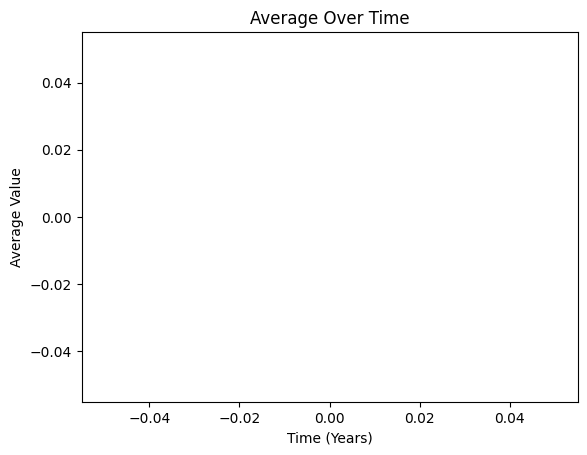

In [88]:
# plt.plot()
# plt.xlabel('Time (Years)')
# plt.ylabel('Average Value')
# plt.title('Average Over Time')
# plt.show()

## Economic Data

In [89]:
gdp_fp = r"C:\Users\GriffenRoweGaddis\OneDrive - Kubrick Group\Desktop\Training\Projects\Bank Churn\data\gdp.csv"
ff_fp = r"C:\Users\GriffenRoweGaddis\OneDrive - Kubrick Group\Desktop\Training\Projects\Bank Churn\data\FEDFUNDS.csv"
unem_fp = r"C:\Users\GriffenRoweGaddis\OneDrive - Kubrick Group\Desktop\Training\Projects\Bank Churn\data\UNRATE.csv"

gdp_df = pd.read_csv(gdp_fp)
fedfunds_df = pd.read_csv(ff_fp)
unem_df = pd.read_csv(unem_fp)

In [90]:
gdp_df.head()

,DATE,A191RL1Q225SBEA
0,1947-04-01,-1.1
1,1947-07-01,-0.8
2,1947-10-01,6.4
3,1948-01-01,6.2
4,1948-04-01,6.8


In [91]:
fedfunds_df.head()

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [92]:
unem_df.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


## Feature Engineering

#### To-do:
1) Join the starting balance to the transactions df.
2) Aggregate by month, cust ID
3) Create new features
4) Create visualizations
5) Create feature to be our response

##### Features to add
- Monthly start balance
  - Have to include the start balance as the first month balance for each customer ID
  - Then the next month will be the monthly end balance for each customer ID
- Monthly end balance
  - Have to add the `amount` column to the monthly start for each customer_ID and month combo
  - Then this will be the monthly start balance for each customer

- Average withdrawal amount
- Average deposit amount
- Average monthly start/end balance
- Binary variable that indicates whether or not they have $0.00 monthly ending balance
  - Avg time to have $0.00 monthly ending balance
  - Amount of months in a row having $0.00 ending balance per customer ID
- Binary variable that indicates whether number of months having $0.00 is above average
  - Can create another feature that indicates 
- Number of transactions per account (per month?)
  - Cust_df
  - Avg number of transactions per account per month
    - S.d. too
-

##### Visualizations to make
- Histograms for each continuous variable to see distribution
- Total number of accounts per year over time
- Average deposit/withdrawal amount over time
- 

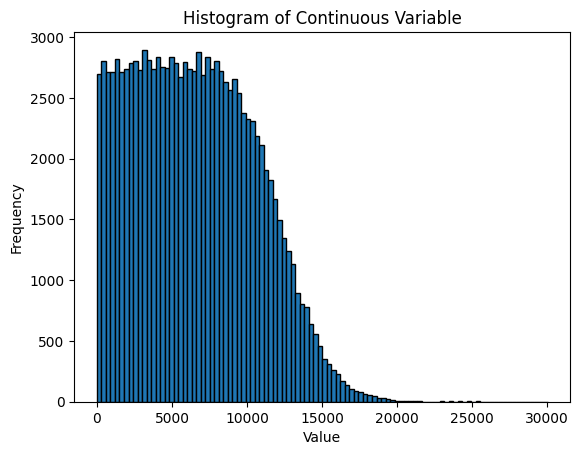

In [93]:
# Check start_balance
filtered_data = cust_df[cust_df['start_balance'] <= 20000000]

plt.hist(filtered_data['start_balance'], bins=100,edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Start Balance')

# Display the plot
plt.show()


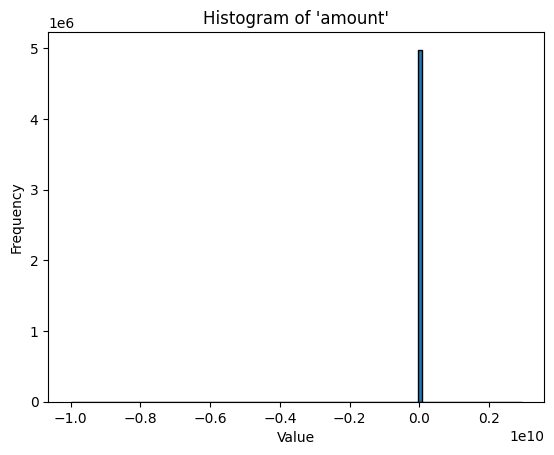

In [94]:
plt.hist(trans_df['amount'], bins=100,edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("Histogram of 'amount'")

# Display the plot
plt.show()

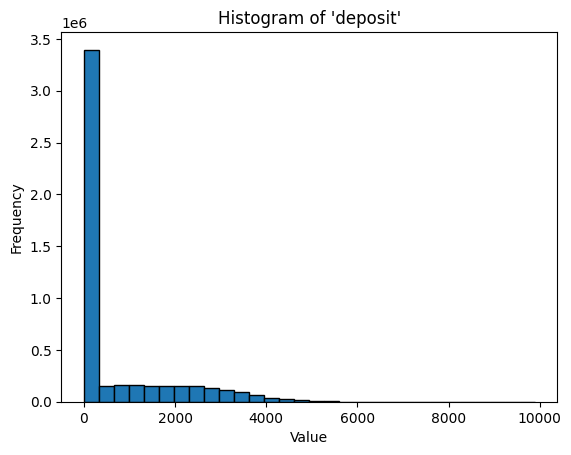

In [95]:
plt.hist(trans_df['deposit'], bins=30,edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("Histogram of 'deposit'")

# Display the plot
plt.show()

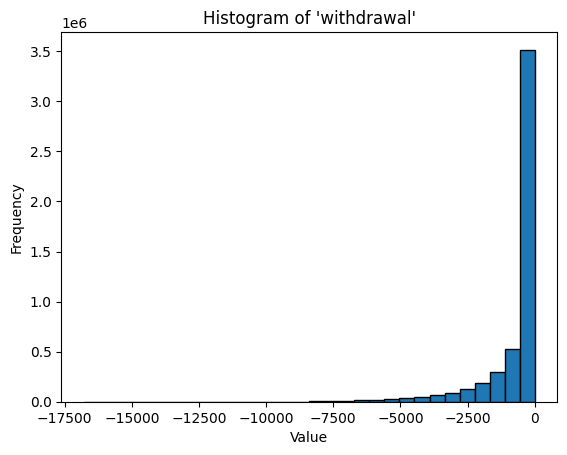

In [96]:
plt.hist(trans_df['withdrawal'], bins=30,edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("Histogram of 'withdrawal'")

# Display the plot
plt.show()

In [97]:
customer_count = trans_df.groupby('year')['customer_id'].nunique()

Text(0.5, 1.0, 'Total Number of Active Customers Over Time')

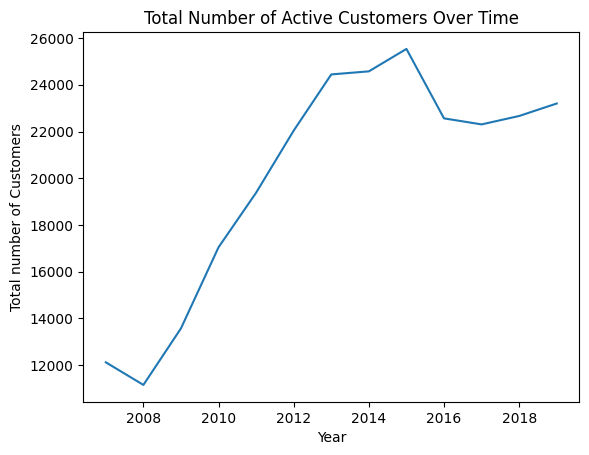

In [98]:
data_to_plot = customer_count.iloc[:-1]
data_to_plot.plot()

plt.xlabel('Year')
plt.ylabel('Total number of Customers')
plt.title('Total Number of Active Customers Over Time')

In [99]:
avg_dep = trans_df.groupby('year')['deposit'].mean()
avg_with = trans_df.groupby('year')['withdrawal'].mean()

Text(0.5, 1.0, 'Average withdrawal amount over time')

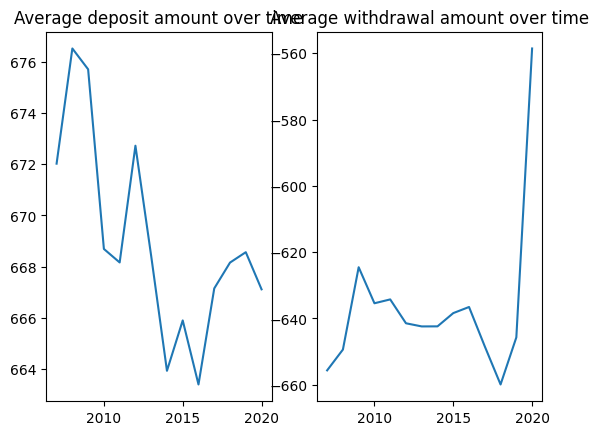

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(avg_dep)
ax1.set_title("Average deposit amount over time")

ax2.plot(avg_with)
ax2.set_title("Average withdrawal amount over time")

### First attempt at a model:
- y = risk_churn
- features = age, state dummies, start balance, 

### Response variable idea:
- If average number of monthly transactions is below avg(monthly_transaction_count) - 2 * sd(monthly_transaction_count)
- AND if ending monthly balance is below a threshold for a specific amount of time.

In [30]:
display(cust_df)


,customer_id,dob,state,start_balance,creation_date,num_trans,z_scores,risk_churn
0,91,1993-07-01,California,10180.56,2007-01-31,6,-0.917908,0
1,92,1985-12-05,New York,4757.68,2007-01-31,31,-0.296138,0
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,29,-0.345880,0
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,33,-0.246397,0
4,95,1970-04-06,California,12500.72,2007-01-31,47,0.101794,0
...,...,...,...,...,...,...,...,...
116010,116102,1969-03-02,Georgia,3110.96,2020-05-31,2,-1.017391,1
116011,116103,1966-10-25,New York,12063.92,2020-05-31,3,-0.992520,0
116012,116104,1986-04-30,Oklahoma,11011.36,2020-05-31,2,-1.017391,1
116013,116105,1983-08-25,New Mexico,8861.08,2020-05-31,1,-1.042261,1


In [34]:
print(cust_df["start_balance"].max()) #-10000000000.0 needs to be dropped
outliers = cust_df[(cust_df['start_balance'] >= 1000000.0)]
cust_df = cust_df.drop(outliers.index)

2000000000.0


In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

C:\Users\GriffenRoweGaddis\AppData\Local\Temp\ipykernel_22688\4230033111.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_df['num_trans'] = scaler.fit_transform(clust_df['num_trans'].values.reshape(-1, 1))
c:\Users\GriffenRoweGaddis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\GriffenRoweGaddis\AppData\Local\Temp\ipykernel_22688\4230033111.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

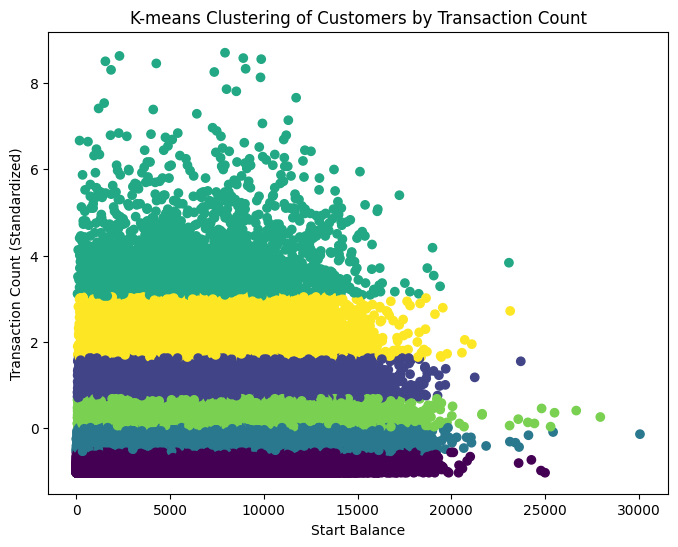

In [39]:
# use k-means to cluster customers based upon number of transactions
selected_features = ['customer_id', 'num_trans','start_balance']
clust_df = cust_df[selected_features]

# Standardize the transaction_count column
scaler = StandardScaler()
clust_df['num_trans'] = scaler.fit_transform(clust_df['num_trans'].values.reshape(-1, 1))

# Determine the number of clusters
num_clusters = 6

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(clust_df[['num_trans']])

# Assign cluster labels to each customer
clust_df['cluster_label'] = kmeans.labels_

cluster_counts = clust_df['cluster_label'].value_counts()
cluster_means = clust_df.groupby('cluster_label')['num_trans'].mean()

# visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(clust_df['start_balance'], clust_df['num_trans'], c=clust_df['cluster_label'], cmap='viridis')
plt.xlabel('Start Balance')
plt.ylabel('Transaction Count (Standardized)')
plt.title('K-means Clustering of Customers by Transaction Count')
plt.show()

### Features to include in model: